# Stock price prediction using LSTM neural network and Tensorflow
What do we need here:
1. Load data
2. Scale data for machine learning model
3. Setup neural network
4. Compile model
5. Teach neural netowk and fit this
6. Use the model for prediction
7. Draw the results chart

In [1]:
# Requirements
!pip install yahoo_fin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.3 MB/s eta 0:00:00
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=240fd948742027289b88d10fa1b68eab6071f434f34ffe137e8d7b55ac541588
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=601cd8dca8b4147002e9af65bad2f1ad3134dc59229da7595f77912b33f4e1cf
  Stored in directory: /root/.cache/pip/wheels/f0/69/93/a47e9d621be168e9e33c7ce60524393c0b92ae83cf6c6e89c5
Successfully built bs4 sgmllib3k
  Attempting uninstall: urllib3
    Found existing 

In [2]:
import numpy as np
import time as tm
import datetime as dt
import tensorflow as tf

# Data preparation
from yahoo_fin import stock_info as yf
from sklearn.preprocessing import MinMaxScaler
from collections import deque

# AI
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Graphics library
import matplotlib.pyplot as plt

In [3]:
# SETTINGS

# Window size or the sequence length, 7 (1 week)
N_STEPS = 7

# Lookup steps, 1 is the next day, 3 = after tomorrow
LOOKUP_STEPS = [1, 2, 3]

# Stock ticker, GOOGL
STOCK = 'GOOGL'

# Current date
date_now = tm.strftime('%Y-%m-%d')
date_3_years_back = (dt.date.today() - dt.timedelta(days=1104)).strftime('%Y-%m-%d')

In [4]:
# LOAD DATA
# from yahoo_fin
# for 1104 bars with interval = 1d (one day)
init_df = yf.get_data(
    STOCK,
    start_date=date_3_years_back,
    end_date=date_now,
    interval='1d')

In [5]:
init_df

,open,high,low,close,adjclose,volume,ticker
2020-09-11,76.407501,76.934998,74.651001,75.788002,75.788002,30706000,GOOGL
2020-09-14,76.582497,77.849998,75.255501,75.441498,75.441498,42660000,GOOGL
2020-09-15,76.394501,77.549500,76.105003,76.755997,76.755997,23042000,GOOGL
2020-09-16,77.124001,77.718498,75.579498,75.604500,75.604500,22128000,GOOGL
2020-09-17,74.290497,74.932999,73.123001,74.351997,74.351997,40008000,GOOGL
...,...,...,...,...,...,...,...
2023-09-13,135.089996,136.899994,134.149994,136.710007,136.710007,20749500,GOOGL
2023-09-14,137.600006,138.699997,136.240005,138.100006,138.100006,24751000,GOOGL
2023-09-15,137.979996,138.520004,136.479996,137.399994,137.399994,38908400,GOOGL
2023-09-18,136.610001,139.160004,136.610001,138.210007,138.210007,21861300,GOOGL


In [6]:
# remove columns which our neural network will not use
init_df = init_df.drop(['open', 'high', 'low', 'adjclose', 'ticker', 'volume'], axis=1)
# create the column 'date' based on index column
init_df['date'] = init_df.index

In [7]:
init_df

,close,date
2020-09-11,75.788002,2020-09-11
2020-09-14,75.441498,2020-09-14
2020-09-15,76.755997,2020-09-15
2020-09-16,75.604500,2020-09-16
2020-09-17,74.351997,2020-09-17
...,...,...
2023-09-13,136.710007,2023-09-13
2023-09-14,138.100006,2023-09-14
2023-09-15,137.399994,2023-09-15
2023-09-18,138.210007,2023-09-18


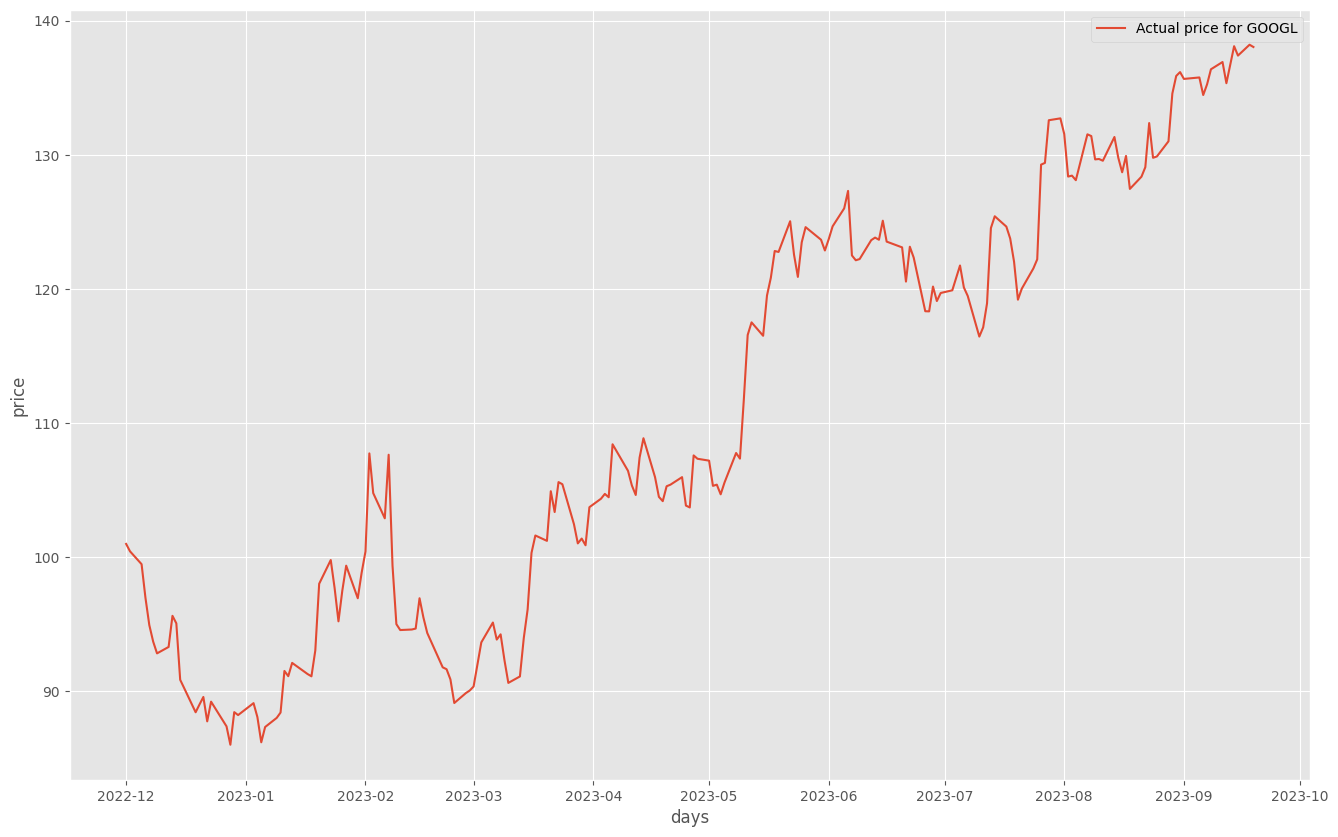

In [8]:
# Let's preliminary see our data on the graphic
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(init_df['close'][-200:])
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}'])
plt.show()

In [9]:
# Scale data for ML engine
scaler = MinMaxScaler()
init_df['scaled_close'] = scaler.fit_transform(np.expand_dims(init_df['close'].values, axis=1))

In [10]:
init_df

,close,date,scaled_close
2020-09-11,75.788002,2020-09-11,0.067010
2020-09-14,75.441498,2020-09-14,0.062644
2020-09-15,76.755997,2020-09-15,0.079206
2020-09-16,75.604500,2020-09-16,0.064698
2020-09-17,74.351997,2020-09-17,0.048917
...,...,...,...
2023-09-13,136.710007,2023-09-13,0.834589
2023-09-14,138.100006,2023-09-14,0.852102
2023-09-15,137.399994,2023-09-15,0.843283
2023-09-18,138.210007,2023-09-18,0.853488


In [11]:
def PrepareData(days):
  df = init_df.copy()
  df['future'] = df['scaled_close'].shift(-days)
  last_sequence = np.array(df[['scaled_close']].tail(days))
  df.dropna(inplace=True)
  sequence_data = []
  sequences = deque(maxlen=N_STEPS)

  for entry, target in zip(df[['scaled_close'] + ['date']].values, df['future'].values):
      sequences.append(entry)
      if len(sequences) == N_STEPS:
          sequence_data.append([np.array(sequences), target])

  last_sequence = list([s[:len(['scaled_close'])] for s in sequences]) + list(last_sequence)
  last_sequence = np.array(last_sequence).astype(np.float32)

  # construct the X's and Y's
  X, Y = [], []
  for seq, target in sequence_data:
      X.append(seq)
      Y.append(target)

  # convert to numpy arrays
  X = np.array(X)
  Y = np.array(Y)

  return df, last_sequence, X, Y

In [12]:
PrepareData(3) # 3 days

(                 close       date  scaled_close    future
 2020-09-11   75.788002 2020-09-11      0.067010  0.064698
 2020-09-14   75.441498 2020-09-14      0.062644  0.048917
 2020-09-15   76.755997 2020-09-15      0.079206  0.026270
 2020-09-16   75.604500 2020-09-16      0.064698  0.013072
 2020-09-17   74.351997 2020-09-17      0.048917  0.031769
 ...                ...        ...           ...       ...
 2023-09-08  136.380005 2023-09-08      0.830431  0.834589
 2023-09-11  136.919998 2023-09-11      0.837235  0.852102
 2023-09-12  135.339996 2023-09-12      0.817328  0.843283
 2023-09-13  136.710007 2023-09-13      0.834589  0.853488
 2023-09-14  138.100006 2023-09-14      0.852102  0.851346
 
 [757 rows x 4 columns],
 array([[0.80624056],
        [0.8163199 ],
        [0.83043134],
        [0.8372349 ],
        [0.81732786],
        [0.8345891 ],
        [0.8521023 ],
        [0.8432826 ],
        [0.8534882 ],
        [0.85134614]], dtype=float32),
 array([[[0.0670098415330728

In [13]:
def GetTrainedModel(x_train, y_train):
  model = Sequential()
  model.add(LSTM(60, return_sequences=True, input_shape=(N_STEPS, len(['scaled_close']))))
  model.add(Dropout(0.3))
  model.add(LSTM(120, return_sequences=False))
  model.add(Dropout(0.3))
  model.add(Dense(20))
  model.add(Dense(1))

  BATCH_SIZE = 8
  EPOCHS = 80

  model.compile(loss='mean_squared_error', optimizer='adam')

  model.fit(x_train, y_train,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            verbose=1)

  model.summary()

  return model

In [14]:
# GET PREDICTIONS
predictions = []

for step in LOOKUP_STEPS:
  df, last_sequence, x_train, y_train = PrepareData(step)
  x_train = x_train[:, :, :len(['scaled_close'])].astype(np.float32)

  model = GetTrainedModel(x_train, y_train)

  last_sequence = last_sequence[-N_STEPS:]
  last_sequence = np.expand_dims(last_sequence, axis=0)
  prediction = model.predict(last_sequence)
  predicted_price = scaler.inverse_transform(prediction)[0][0]

  predictions.append(round(float(predicted_price), 2))

Epoch 1/80
95/95 [==============================] - 6s 11ms/step - loss: 0.0188
Epoch 2/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0052
Epoch 3/80
95/95 [==============================] - 1s 10ms/step - loss: 0.0054
Epoch 4/80
95/95 [==============================] - 1s 11ms/step - loss: 0.0044
Epoch 5/80
95/95 [==============================] - 2s 19ms/step - loss: 0.0043
Epoch 6/80
95/95 [==============================] - 3s 28ms/step - loss: 0.0045
Epoch 7/80
95/95 [==============================] - 2s 23ms/step - loss: 0.0037
Epoch 8/80
95/95 [==============================] - 2s 19ms/step - loss: 0.0036
Epoch 9/80
95/95 [==============================] - 2s 20ms/step - loss: 0.0040
Epoch 10/80
95/95 [==============================] - 2s 22ms/step - loss: 0.0035
Epoch 11/80
95/95 [==============================] - 2s 22ms/step - loss: 0.0029
Epoch 12/80
95/95 [==============================] - 2s 26ms/step - loss: 0.0028
Epoch 13/80
95/95 [==================

In [15]:
score = model.evaluate(x_train, y_train)
print('Test loss:', score)

24/24 [==============================] - 1s 6ms/step - loss: 0.0026
Test loss: 0.002579210326075554


In [16]:
if bool(predictions) == True and len(predictions) > 0:
  predictions_list = [str(d)+'$' for d in predictions]
  predictions_str = ', '.join(predictions_list)
  message = f'{STOCK} prediction for upcoming 3 days ({predictions_str})'

  print(message)

GOOGL prediction for upcoming 3 days (137.32$, 138.66$, 139.4$)


In [17]:
# Execute model for the whole history range
copy_df = init_df.copy()
y_predicted = model.predict(x_train)
y_predicted_transformed = np.squeeze(scaler.inverse_transform(y_predicted))
first_seq = scaler.inverse_transform(np.expand_dims(y_train[:6], axis=1))
last_seq = scaler.inverse_transform(np.expand_dims(y_train[-3:], axis=1))
y_predicted_transformed = np.append(first_seq, y_predicted_transformed)
y_predicted_transformed = np.append(y_predicted_transformed, last_seq)
copy_df[f'predicted_close'] = y_predicted_transformed

24/24 [==============================] - 0s 7ms/step


In [18]:
copy_df

,close,date,scaled_close,predicted_close
2020-09-11,75.788002,2020-09-11,0.067010,71.142998
2020-09-14,75.441498,2020-09-14,0.062644,71.953003
2020-09-15,76.755997,2020-09-15,0.079206,72.932999
2020-09-16,75.604500,2020-09-16,0.064698,73.301003
2020-09-17,74.351997,2020-09-17,0.048917,73.279999
...,...,...,...,...
2023-09-13,136.710007,2023-09-13,0.834589,137.754410
2023-09-14,138.100006,2023-09-14,0.852102,138.780731
2023-09-15,137.399994,2023-09-15,0.843283,137.399994
2023-09-18,138.210007,2023-09-18,0.853488,138.210007


In [19]:
# Add predicted results to the table
date_now = dt.date.today()
date_tomorrow = dt.date.today() + dt.timedelta(days=1)
date_after_tomorrow = dt.date.today() + dt.timedelta(days=2)

copy_df.loc[date_now] = [predictions[0], f'{date_now}', 0, 0]
copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]

<ipython-input-19-ca1349af6c77>:7: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_tomorrow] = [predictions[1], f'{date_tomorrow}', 0, 0]
<ipython-input-19-ca1349af6c77>:8: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  copy_df.loc[date_after_tomorrow] = [predictions[2], f'{date_after_tomorrow}', 0, 0]


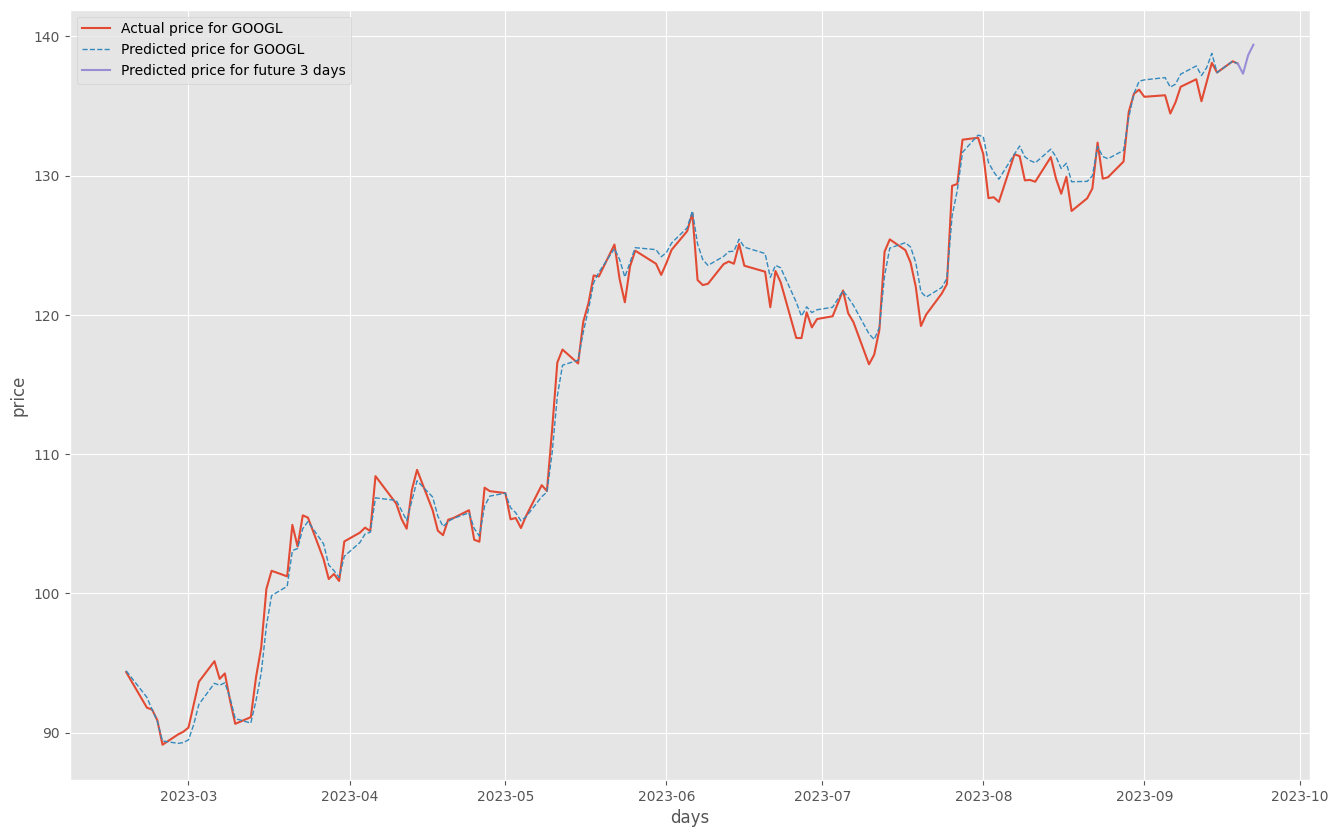

In [20]:
# Result chart
plt.style.use(style='ggplot')
plt.figure(figsize=(16,10))
plt.plot(copy_df['close'][-150:].head(147))
plt.plot(copy_df['predicted_close'][-150:].head(147), linewidth=1, linestyle='dashed')
plt.plot(copy_df['close'][-150:].tail(4))
plt.xlabel('days')
plt.ylabel('price')
plt.legend([f'Actual price for {STOCK}',
            f'Predicted price for {STOCK}',
            f'Predicted price for future 3 days'])
plt.show()

In [23]:


from tensorflow import keras

# Assuming 'model' is your trained TensorFlow model
model.save('my_model.h5')  # Save the model as an H5 file


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
